## Modelling the dynamics of football with Markov chains

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pydtmc as dtmc
from matplotlib import animation, rc
import os 
import inspect

### Data Cleaning and Visualisation 

In [2]:
# read in the data
players = pd.read_json("data/players.json")
matches = pd.read_json("data/matches/matches_England.json")
events = pd.read_json("data/events/events_England.json")
teams = pd.read_json("data/teams.json")

In [3]:
# look at the events data
events[20:]

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
20,8,Pass,35.685082,177959184,2499719,1H,370224,"[{'y': 81, 'x': 37}, {'y': 95, 'x': 45}]",82,Head pass,[{'id': 1802}],1609
21,8,Pass,36.661264,177959204,2499719,1H,14763,"[{'y': 5, 'x': 55}, {'y': 22, 'x': 67}]",82,Head pass,[{'id': 1801}],1631
22,1,Duel,38.191874,177959205,2499719,1H,12829,"[{'y': 22, 'x': 67}, {'y': 15, 'x': 71}]",13,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",1631
23,1,Duel,38.191874,177961219,2499719,1H,0,"[{'y': 78, 'x': 33}, {'y': 85, 'x': 29}]",13,Ground loose ball duel,"[{'id': 701}, {'id': 1802}]",1609
24,8,Pass,39.940109,177959206,2499719,1H,14763,"[{'y': 15, 'x': 71}, {'y': 26, 'x': 81}]",86,Smart pass,"[{'id': 901}, {'id': 1802}]",1631
25,8,Pass,43.045831,177959185,2499719,1H,3560,"[{'y': 74, 'x': 19}, {'y': 53, 'x': 4}]",85,Simple pass,[{'id': 1801}],1609
26,8,Pass,44.425679,177959187,2499719,1H,7882,"[{'y': 53, 'x': 4}, {'y': 44, 'x': 40}]",84,Launch,[{'id': 1801}],1609
27,1,Duel,47.717508,177959210,2499719,1H,192748,"[{'y': 56, 'x': 60}, {'y': 49, 'x': 56}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631
28,1,Duel,48.265872,177959188,2499719,1H,7945,"[{'y': 44, 'x': 40}, {'y': 51, 'x': 44}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1609
29,1,Duel,49.182566,177959213,2499719,1H,149019,"[{'y': 49, 'x': 56}, {'y': 54, 'x': 45}]",12,Ground defending duel,"[{'id': 504}, {'id': 701}, {'id': 1802}]",1631


In [5]:
# extracts ball positions so that the home team attacks towards x=100. Also extract possession 
def label_xy_coord_poss(row):
    ''' function to add three new columns giving team in possession and x,y coordinates'''
    team1 = int(list(matches[matches.wyId == row.matchId]['teamsData'].values[0].keys())[0])
    if row.teamId == team1:
        x = row['positions'][0]['x']
        y = row['positions'][0]['y']
        poss = 1
    else: 
        x = 100 - row['positions'][0]['x']
        y = 100 - row['positions'][0]['y']
        poss = 2 
    return [x, y, poss]

def label_goal(row):
    ''' function to add goal: yes/no columns'''
    return {'id':101} in row['tags']

Add the extra columns to the dataframe. (there must be a faster way of doing this????)

In [ ]:
# add new collumns to data frame (takes about 10 mins)
events['goal'] = events.apply(lambda row: label_goal(row), axis=1)
events['new_col'] = events.apply(lambda row: label_xy_coord_poss(row), axis=1)
events[['x_coord', 'y_coord', 'poss']] = pd.DataFrame(events['new_col'].tolist())
events = events.drop('new_col', 1)

In [141]:
# fixing various glitches in the data. Shots going to the corner, goalkicks having the wrong coordinates,...
events["x_coord"] = events["x_coord"].where((events["x_coord"] !=0) | (events["y_coord"]!=0)
                                           | (events["subEventName"]=="Corner"), 0)
events["y_coord"] = events["y_coord"].where((events["x_coord"] !=0) | (events["y_coord"]!=0)
                                           | (events["subEventName"]=="Corner"), 50)
events["y_coord"] = events["y_coord"].where((events["x_coord"] !=100) | (events["y_coord"]!=100)
                                           | (events["subEventName"]=="Corner"), 50)
events["x_coord"] = events["x_coord"].where((events["eventName"] != "Save attempt") 
                                           | (events["poss"] == 1), 100)
events["x_coord"] = events["x_coord"].where((events["eventName"] != "Save attempt") 
                                            | (events["poss"] == 2), 0)
events["y_coord"] = events["y_coord"].where(events["eventName"] != "Save attempt", 50)
events["x_coord"] = events['x_coord'].where((events['subEventName'] != 'Goal kick') | (events['poss'] == 1),100)

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
121,364,2018-02-04 18:30:00,2018-02-04 16:30:00,Regular,26,"Liverpool - Tottenham Hotspur, 2 - 2",[],4405654,181150,Played,"{'1612': {'scoreET': 0, 'coachId': 0, 'side': ...",Anfield,0,2499975


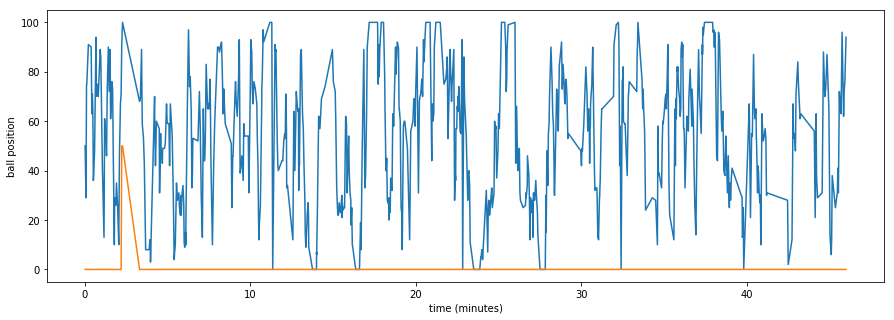

In [143]:
# Plots the time-series of the x coordinate of the ball for a given match 
K = np.random.randint(0, 600000);
match = events[events.matchId == events.iloc[K]['matchId']]
match = match[match.matchPeriod == '1H']
time = match.eventSec.values; x = match.x_coord.values; y = match.y_coord.values
goals = match.goal; poss = match.poss
matches[matches.wyId == events.iloc[K]['matchId']]
plt.figure(figsize=(15,5))
plt.plot(time/60, x, label='ball position');
plt.plot(time/60, 50*goals, label='goals');
plt.xlabel("time (minutes)"); plt.ylabel("ball position");
#plt.scatter(time[N1:N2]/60, 50*(2*poss[N1:N2]-2), s=0.1, label='poseesion');
matches[matches.wyId == events.iloc[K]['matchId']]

In [145]:
events[(events["x_coord"] == 0) & (events["y_coord"]==0)]

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,goal,x_coord,y_coord,poss
825,3,Free Kick,2615.521271,177960053,2499719,1H,26150,"[{'y': 100, 'x': 100}, {'y': 83, 'x': 79}]",30,Corner,[{'id': 1801}],1631,False,0,0,2
849,3,Free Kick,2674.664029,177960080,2499719,1H,26150,"[{'y': 100, 'x': 100}, {'y': 55, 'x': 93}]",30,Corner,"[{'id': 801}, {'id': 1801}]",1631,False,0,0,2
1888,3,Free Kick,331.965385,178147434,2499720,1H,38021,"[{'y': 100, 'x': 100}, {'y': 74, 'x': 84}]",30,Corner,[{'id': 1801}],1625,False,0,0,2
2170,3,Free Kick,1401.383496,178147733,2499720,1H,38021,"[{'y': 100, 'x': 100}, {'y': 62, 'x': 91}]",30,Corner,"[{'id': 801}, {'id': 1801}]",1625,False,0,0,2
2917,3,Free Kick,1205.187056,178148496,2499720,2H,38021,"[{'y': 100, 'x': 100}, {'y': 84, 'x': 89}]",30,Corner,[{'id': 1801}],1625,False,0,0,2
2941,3,Free Kick,1304.620507,178148515,2499720,2H,38021,"[{'y': 100, 'x': 100}, {'y': 79, 'x': 60}]",30,Corner,[{'id': 1801}],1625,False,0,0,2
3314,3,Free Kick,2745.839065,178148916,2499720,2H,38021,"[{'y': 100, 'x': 100}, {'y': 81, 'x': 87}]",30,Corner,[{'id': 1801}],1625,False,0,0,2
4164,3,Free Kick,2668.771974,178122854,2499721,1H,3350,"[{'y': 100, 'x': 100}, {'y': 50, 'x': 91}]",30,Corner,"[{'id': 801}, {'id': 1801}]",1610,False,0,0,2
4478,3,Free Kick,963.778955,178123233,2499721,2H,3350,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 95}]",30,Corner,"[{'id': 801}, {'id': 1801}]",1610,False,0,0,2
4574,3,Free Kick,1357.462696,178123315,2499721,2H,105333,"[{'y': 100, 'x': 100}, {'y': 70, 'x': 88}]",30,Corner,[{'id': 1801}],1610,False,0,0,2


### Building the big Markov chain - Method 1: Non-parametric approximation of transition probabilities
We assume that the dynamics are described by a discrete time Markov process on the state space 
$$ X = [0,100]^2\times \{1,2\} $$
where the $[0,100]^2$ component describes the position of the ball, and $\{1,2\}$ describes which team has possession of the ball. (Team 1 attacks towards $x=100$ and Team 2 attacks towards $x=0$). We now use our data to estimate the transition probabilities of this process. 

In [146]:
# function mapping x-y coordinates to discretised integer indexed boxes for Markov chain fitting 
res = 5
num = int(100/res + 2)
def flatten(x, y, poss, res = 5):
    # treat x,y=0 and x,y=100 as separate cases because the ball is out of play
    num = int(100/res + 2)
    x0 = np.where(x == 0, x, x // res + 1)
    y0 = np.where(y == 0, y, y // res + 1)
    
    return  num*x0 + y0 + np.where(poss == 1, 0, 1)*num**2
        
def unflatten(X, res = 5):
    num = int(100/res + 2) 
    poss = np.where(X > num**2-1, 2, 1)
    X = X - (poss - 1)*num**2
    x = np.divmod(X, num )[0]; y = np.divmod(X, num )[1]
    return x, y, poss

unflatten(201)

(9, 3, array(1))

In [149]:
X = flatten(events['x_coord'], events['y_coord'], events['poss'])
states = np.linspace(0,2*num**2 - 1,2*num**2)
P = dtmc.fitting.fit_walk(fitting_type = 'mle', walk = X,
                         possible_states = states , k = 0)[0]

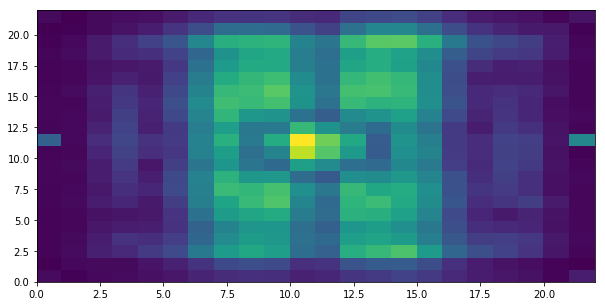

In [156]:
# Convert each transition function into matrix so it can be visualised
np.sum(P[0,:])
# function plotting the probability of the next events in x,y space, summing over possession
Pn = np.linalg.matrix_power(P,3)
def P_vis(x,y,p):
    k = flatten(x,y,p)
    P_vis = np.zeros((num,num))
    for j in range(len(P)):
        x0,y0,p = unflatten(j)
        P_vis[int(x0), int(y0)] += Pn[k,j]
    return P_vis

# function plotting the probability of dispossesion as a function of x,y
def P_pos(p, p_bar):
    P_pos = np.zeros((num,num))
    for i in range(len(P)):
        x0, y0, p0 = unflatten(i)
        for j in range(len(P)):
            x1, y1, p1 = unflatten(j)
            if (p0 == p) and (p1 == p_bar):
                P_pos[int(x0), int(y0)] += P[i,j]
    return P_pos

        
plt.figure(figsize=(10,5))
plt.pcolor(P_vis(40,50,1).T);
#plt.figure(figsize=(10,5))
#plt.pcolor(P_pos(2,2).T);
#np.max(P_pos(2,2))

This gives the gives of positions of the next event, which is a bit wierd because of the way duels are recorded. It would be better to sample every second (say) and interpolate the values. 

### Method 2: A parametric model 
So far we have estimated the transition probabilities of the Markov process by discreting the state space and empircally estimating the transition probabiities from the data. We can also propose a parameterised form of these transition probabilities based on our knowledge of the game, and then try to estimate these parameters. A simple model could be given by 
$$ \begin{pmatrix} x_{n+1} \\ y_{n+1} \end{pmatrix} = \begin{pmatrix} x_n \\ y_n \end{pmatrix} + \alpha\left(\mathrm{Goal}(P_n) - \begin{pmatrix} x_n \\ y_n \end{pmatrix}\right) + \sigma \begin{pmatrix} \xi_n^1\\ \xi_n^2 \end{pmatrix}  $$
where $\mathrm{Goal}(P)$ gives the position of the goal that team $P$ is attacking, $\alpha,\sigma>0, $ are two parameters to be estimated and $(\xi_n^1,\xi_n^2)$ are a sequence of i.i.d. (say normally distributed) random variables. When a team has the ball they try to get it closer to their opponent's goal. 

In [1482]:
small_events = events.iloc[0:1000,:]
small_events.pop('eventName')
small_events.pop('subEventName')

0                 Simple pass
1                   High pass
2                   Head pass
3                   Head pass
4                 Simple pass
5                 Simple pass
6                   Head pass
7                    Air duel
8                    Air duel
9                   Head pass
10                  Head pass
11                  High pass
12                   Air duel
13                   Air duel
14                  High pass
15                  Head pass
16                  Head pass
17                Simple pass
18                Simple pass
19                  High pass
20                  Head pass
21                  Head pass
22     Ground loose ball duel
23     Ground loose ball duel
24                 Smart pass
25                Simple pass
26                     Launch
27                   Air duel
28                   Air duel
29      Ground defending duel
                ...          
970               Simple pass
971               Simple pass
972       